<a href="https://colab.research.google.com/github/Nirav1221/MarioMusicGan/blob/master/MarioGAN_MUSIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Generating Mario Themed music with python.

Instructions
- Change the Runtime type and select **Hardware accelerator** to **GPU**
- Run all the cells in given order
- Output will be generated with name
  ***gan_final.mid***
- Double Click to download file.
- While training,you can change the **epochs** parameter.
- Optional
  - Upload listfile.data
  - Upload descriminator and generator weights and model
  - File Names:
   - Descriminator Model: disc.h5
   - Generator Model: gen.h5
   - Descriminator Weights: dw.h5
   - Generator Weights: gw.h5

Note Directory can be located at


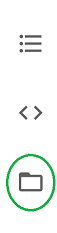



In [0]:
import os
import sys
sys.argv[0]
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==1.14.0
#!pip install tensorflow-gpu==1.14.0


Uninstalling tensorflow-2.2.0rc2:
  Successfully uninstalled tensorflow-2.2.0rc2
     |████████████████████████████████| 377.0MB 31kB/s 
     |████████████████████████████████| 3.2MB 41.6MB/s 
     |████████████████████████████████| 491kB 60.5MB/s 
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0


In [0]:
from __future__ import print_function, division
import sys
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
from music21 import converter, instrument, note, chord, stream
from keras.layers import Input, Dense, Reshape, Dropout, CuDNNLSTM, Bidirectional
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import os
import pickle

def get_notes():
    """ Get all the notes and chords from the midi files """
    notes = []

    for file in glob.glob("MIDIs/*.mid"):
        try:
          midi = converter.parse(file)

          print("Parsing %s" % file)

          notes_to_parse = None

          try: # file has instrument parts
              s2 = instrument.partitionByInstrument(midi)
              notes_to_parse = s2.parts[0].recurse() 
          except: # file has notes in a flat structure
            
              notes_to_parse = midi.flat.notes
              
          for element in notes_to_parse:
              if isinstance(element, note.Note):
                  notes.append(str(element.pitch))
              elif isinstance(element, chord.Chord):
                  notes.append('.'.join(str(n) for n in element.normalOrder))
        except Exception as e:
          continue

    return notes

def prepare_sequences(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 100

    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))

    # Create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # Reshape the input into a format compatible with LSTM layers
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    
    # Normalize input between -1 and 1
    network_input = (network_input - float(n_vocab)/2) / (float(n_vocab)/2)
    network_output = np_utils.to_categorical(network_output)

    return (network_input, network_output)

def generate_notes(model, network_input, n_vocab):
    """ Generate notes from the neural network based on a sequence of notes """
    # pick a random sequence from the input as a starting point for the prediction
    start = numpy.random.randint(0, len(network_input)-1)
    
    # Get pitch names and store in a dictionary
    pitchnames = sorted(set(item for item in notes))
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = numpy.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)
        
        pattern = numpy.append(pattern,index)
        #pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output
  
def create_midi(prediction_output, filename):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for item in prediction_output:
        pattern = item[0]
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='{}.mid'.format(filename))

class GAN():
    def __init__(self, rows):
        self.seq_length = rows
        self.seq_shape = (self.seq_length, 1)
        self.latent_dim = 1000
        self.disc_loss = []
        self.gen_loss =[]
        
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates note sequences
        z = Input(shape=(self.latent_dim,))
        generated_seq = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(generated_seq)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_discriminator(self):
        if(os.path.exists("disc.h5")):
          print("Found Discriminator Model")
          return load_model('disc.h5')
        model = Sequential()
        model.add(CuDNNLSTM(512, input_shape=self.seq_shape, return_sequences=True))
        model.add(Bidirectional(CuDNNLSTM(512)))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        seq = Input(shape=self.seq_shape)
        validity = model(seq)

        return Model(seq, validity)
      
    def build_generator(self):
        if(os.path.exists("gen.h5")):
          print("Found Generator Model")
          return load_model('gen.h5')
        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.seq_shape), activation='tanh'))
        model.add(Reshape(self.seq_shape))
        model.summary()
        
        noise = Input(shape=(self.latent_dim,))
        seq = model(noise)

        return Model(noise, seq)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load and convert the data
        if not os.path.exists('listfile.data'):
          print('Extracting notes from midi')
          notes = get_notes()
          with open('listfile.data', 'wb') as filehandle:
            pickle.dump(notes, filehandle)
        else:
          with open('listfile.data', 'rb') as filehandle:
            notes = pickle.load(filehandle)
          print('Loading notes from file.')
        #notes = get_notes()
        #print('notes type : ',type(notes),notes)
        
        n_vocab = len(set(notes))
        X_train, y_train = prepare_sequences(notes, n_vocab)

        # Adversarial ground truths
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # Training the model
        for epoch in range(epochs):
            if(os.path.exists("dw.h5") and os.path.exists("gw.h5")  ):
              self.discriminator.load_weights("dw.h5")
              self.generator.load_weights("gw.h5")
              break
            # Training the discriminator
            # Select a random batch of note sequences
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_seqs = X_train[idx]

            #noise = np.random.choice(range(484), (batch_size, self.latent_dim))
            #noise = (noise-242)/242
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new note sequences
            gen_seqs = self.generator.predict(noise)

            # Train the discriminator
            
            d_loss_real = self.discriminator.train_on_batch(real_seqs, real)
            d_loss_fake = self.discriminator.train_on_batch(gen_seqs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            

            #  Training the Generator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as real)
            g_loss = self.combined.train_on_batch(noise, real)

            # Print the progress and save into loss lists
            if epoch % sample_interval == 0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
              self.disc_loss.append(d_loss[0])
              self.gen_loss.append(g_loss)
        else:
          self.discriminator.save_weights("dw.h5")
          self.generator.save_weights("gw.h5")
          self.discriminator.save("disc.h5")
          self.generator.save('gen.h5')
        '''
        if not (os.path.exists('Out')):
            os.mkdir('Out')
            os.chdir('Out')
        '''
        self.generate(notes)
        self.plot_loss()
        
    def generate(self, input_notes):
        # Get pitch names and store in a dictionary
        notes = input_notes
        pitchnames = sorted(set(item for item in notes))
        int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
        
        # Use random noise to generate sequences
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        predictions = self.generator.predict(noise)
        print(int_to_note)

        pred_notes = [x*242 + 242 for x in predictions[0]]
        print([int(x) for x in pred_notes])
        #pred_notes = [int_to_note[int(x)] for x in pred_notes]
        pred_notes1=[]
        for x in pred_notes:
          try:
            pred_notes1.append(int_to_note[int(x)])
          except KeyError:
            continue  
        create_midi(pred_notes1, out)
        
    def plot_loss(self):
        plt.plot(self.disc_loss, c='red')
        plt.plot(self.gen_loss, c='blue')
        plt.title("GAN Loss per Epoch")
        plt.legend(['Discriminator', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('GAN_Loss_per_Epoch_final.png', transparent=True)
        plt.close()
#dir [out]

if __name__ == '__main__':
  #print(os.pwd())
  
  #k=os.getcwd()
  #print(k)
  try:
    gan = GAN(rows=100)    
    '''
    pwd = sys.argv[1]
    os.chdir(pwd)
    if len(sys.argv) == 3:
      out = sys.argv[2]
    else:
      out='gan_final'
    '''
    out='gan_final'
    gan.train(epochs=10000, batch_size=32, sample_interval=1)
  except Exception as e:
    raise e
    print('Error\n',e)
  #finally:
    #os.chdir(k)